  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Mounted at /content/drive
Found 999 files belonging to 3 classes.


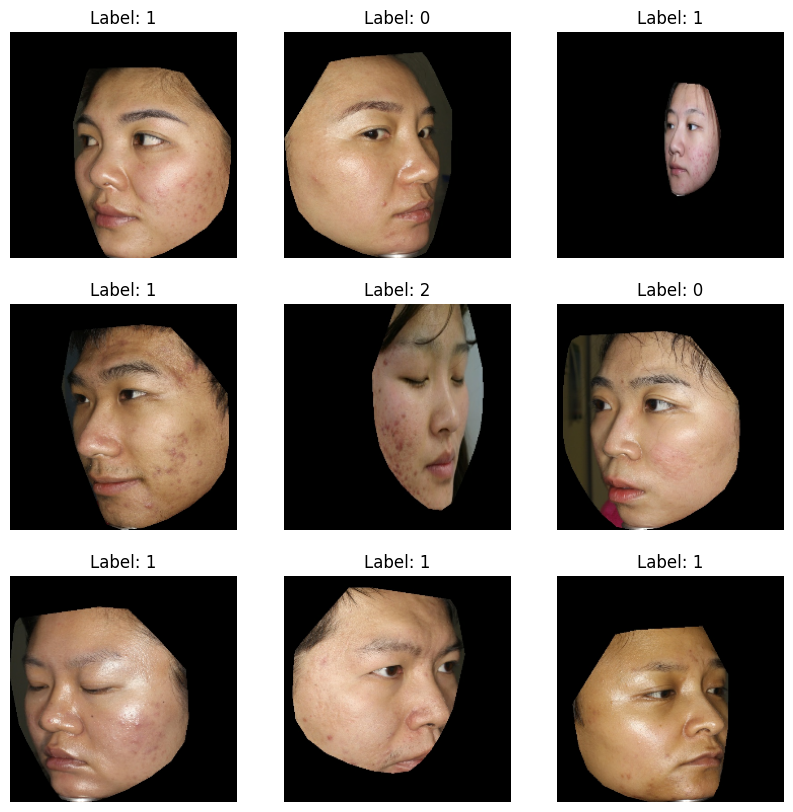

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/25
22/22 [==============================] - 61s 707ms/step - loss: 1.1276 - accuracy: 0.4507 - val_loss: 60.5448 - val_accuracy: 0.4062
Epoch 2/25
22/22 [==============================] - 13s 404ms/step - loss: 0.7656 - accuracy: 0.6333 - val_loss: 2.8014 - val_accuracy: 0.1458
Epoch 3/25
22/22 [==============================] - 12s 409ms/step - loss: 0.6038 - accuracy: 0.7113 - val_loss: 26.0441 - val_accuracy: 0.1916
Epoch 4/25
22/22 [==============================] - 13s 476ms/step - loss: 0.5211 - accuracy: 0.7923 - val_loss: 1.1028 - val_accuracy: 0.5208
Epoch 5/25
22/22 [==============================] - 12s 407ms/step - loss: 0.4848 - accuracy: 0.8012 - val_loss: 0.9474 - val_accuracy: 0.6458
Epoch 6/25
22/22 [==============================] - 12s 428ms/step - loss: 0.4156 - accuracy: 0.8247 - val_loss: 1.9493 - val_accuracy: 0.5312
Epoch 7/25
22/22 [==============================] - 13s 445ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
import os
import numpy as np
from tensorflow.keras.optimizers import SGD

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

# Load and preprocess the data
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Created Dataset"
data = tf.keras.utils.image_dataset_from_directory(data_path, batch_size=32, image_size=(224, 224))
data = data.shuffle(buffer_size=1000, seed=42)
data = data.map(lambda x, y: (x / 255.0, y))  # Scale the pixel values to [0, 1]

# Split the data into training, validation, and test sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)

# Initialize lists to store test data and labels
test_images = []
test_labels = []

# Iterate over the test dataset to extract data and labels
for image, label in test_data:
    test_images.append(image)
    test_labels.append(label)

# Concatenate the lists to get the complete test data and labels
test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

import matplotlib.pyplot as plt

# Iterate over the dataset and display a few examples
for images, labels in train_data.take(1):  # Taking one batch for demonstration
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Displaying 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)
        # Ensure correct scaling and data type
        image = (images[i] * 255).numpy().astype("uint8")
        plt.imshow(image)
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

def create_model1(base_model, activation='softmax'):
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(3, activation=activation)(x)  # 3 classes for acne severity
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model2(base_model, activation='softmax'):
    # Add more layers or change layer configurations
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)  # Additional dense layer
    x = Dense(128, activation='relu')(x)  # Additional dense layer
    output = Dense(3, activation=activation)(x)

    # Change optimizer or learning rate
    optimizer = SGD(learning_rate=0.01, momentum=0.9)  # Use SGD optimizer with different learning rate and momentum
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the base models separately
base_model1 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model1 = create_model1(base_model1)
history1 = model1.fit(train_data, validation_data=val_data, epochs=25 ,verbose=1)

base_model2 = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model2 = create_model2(base_model2)
history2 = model2.fit(train_data, validation_data=val_data, epochs=25, verbose=1)

# Perform predictions for each base model
predictions1 = model1.predict(test_images)
predictions2 = model2.predict(test_images)

# Convert predictions list to numpy arrays
stacked_predictions = np.mean([predictions1, predictions2], axis=0)

# Calculate accuracy for the stacked model
stacked_accuracy = np.sum(np.argmax(stacked_predictions, axis=1) == test_labels) / len(test_labels)
print(f'Stacked Model Test Accuracy: {stacked_accuracy}')

# Combine predictions from base models
combined_predictions = np.concatenate((predictions1, predictions2), axis=1)

# Define and train the stacked model (Logistic Regression)
stacked_model = LogisticRegression(max_iter=1000)
stacked_model.fit(combined_predictions, test_labels)

# Save the trained models
model1.save('model1.h5')
model2.save('model2.h5')

# Load the models
model1_loaded = tf.keras.models.load_model('model1.h5')
model2_loaded = tf.keras.models.load_model('model2.h5')




In [3]:
import tensorflow as tf

# Save model1
model1.save('/content/drive/MyDrive/Models/model1.h5')

# Load model1
loaded_model1 = tf.keras.models.load_model('/content/drive/MyDrive/Models/model1.h5')

# Quantize and save model1
converter1 = tf.lite.TFLiteConverter.from_keras_model(loaded_model1)
converter1.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model1 = converter1.convert()

with open('/content/drive/MyDrive/Models/model1_quantized.tflite', 'wb') as f:
    f.write(tflite_model1)

# Save model2
model2.save('/content/drive/MyDrive/Models/model2.h5')

# Load model2
loaded_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Models/model2.h5')

# Quantize and save model2
converter2 = tf.lite.TFLiteConverter.from_keras_model(loaded_model2)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model2 = converter2.convert()

with open('/content/drive/MyDrive/Models/model2_quantized.tflite', 'wb') as f:
    f.write(tflite_model2)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
import tensorflow as tf

# Save and load model1
model1.save('/content/drive/MyDrive/Models/model1.h5')
loaded_model1 = tf.keras.models.load_model('/content/drive/MyDrive/Models/model1.h5')

# Convert TensorFlow model1 to TensorFlow Lite for mobile deployment
converter1 = tf.lite.TFLiteConverter.from_keras_model(loaded_model1)
converter1.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model1 = converter1.convert()

# Save the TensorFlow Lite model1 to Google Colab
tflite_model1_path = '/content/model1_quantized.tflite'
with open(tflite_model1_path, 'wb') as f:
    f.write(tflite_model1)

print(f'TFLite model1 saved to: {tflite_model1_path}')

# Save and load model2
model2.save('/content/drive/MyDrive/Models/model2.h5')
loaded_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Models/model2.h5')

# Convert TensorFlow model2 to TensorFlow Lite for mobile deployment
converter2 = tf.lite.TFLiteConverter.from_keras_model(loaded_model2)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model2 = converter2.convert()

# Save the TensorFlow Lite model2 to Google Colab
tflite_model2_path = '/content/model2_quantized.tflite'
with open(tflite_model2_path, 'wb') as f:
    f.write(tflite_model2)

print(f'TFLite model2 saved to: {tflite_model2_path}')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TFLite model1 saved to: /content/model1_quantized.tflite


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TFLite model2 saved to: /content/model2_quantized.tflite


In [5]:
import tensorflow as tf


# Save and load model2
model2.save('/content/drive/MyDrive/Models/model2.h5')
loaded_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Models/model2.h5')

# Convert TensorFlow model2 to TensorFlow Lite for mobile deployment
converter2 = tf.lite.TFLiteConverter.from_keras_model(loaded_model2)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model2 = converter2.convert()

# Save the TensorFlow Lite model2 to Google Colab
tflite_model2_path = '/content/model.tflite'
with open(tflite_model2_path, 'wb') as f:
    f.write(tflite_model2)

print(f'TFLite model2 saved to: {tflite_model2_path}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TFLite model2 saved to: /content/model.tflite
